In [65]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import statsmodels.stats.api as sms
import scipy as sp
import scipy.stats
import csv
import helper

def plot_run(path_to_dir):
    df = pd.read_csv(os.path.join(path_to_dir, 'stats_run.csv'))
    # print(df)
    for column in df.columns:
        plt.figure(figsize=(10,6), dpi=80)
        #plt.scatter(df['episode'], df[column])
        plt.plot(df['episode'], df[column],
                 label=column, color='blue', linewidth=2.0)
        plt.ylabel(column, fontsize=20, fontweight='bold')
        plt.xlabel('episodes', fontsize=20, fontweight='bold')
        plt.legend(fontsize=14)
        #plt.savefig(os.path.join(path_to_dir, 'plot_' + str(column) + '.png'))
        plt.show()

def plot_runs(path_to_dir):
    run_dirs = glob.glob(os.path.join(path_to_dir) + '/*/')
    dfs = []
    for run_dir in run_dirs:
        dfs.append(pd.read_csv(os.path.join(run_dir, 'stats_run.csv')))
    for column in dfs[0].columns:
        plt.figure(figsize=(10, 6), dpi=80)
        run_count = 1
        for df in dfs:    
            plt.plot(df['episode'], df[column],
                     label=column+'_'+str(run_count), linewidth=2.0)
            run_count += 1
        plt.ylabel(column, fontsize=20, fontweight='bold')
        plt.xlabel('episodes', fontsize=20, fontweight='bold')
        plt.legend(fontsize=14)
        #plt.savefig(os.path.join(path_to_dir, 'plot_' + str(column) + '.png'))
        plt.show()
            
def summarize_runs_results(path_to_dir):
    run_dirs = glob.glob(os.path.join(path_to_dir) + '/*/')
    run_files = [os.path.join(run_dir, 'stats_run.csv') for run_dir in run_dirs]
    df = pd.concat((pd.read_csv(run_file) for run_file in run_files))
    steps = df.groupby(['episode'])['steps_mean']
    steps = list(steps)
    reward = df.groupby(['episode'])['reward_mean']
    reward = list(reward)
    summary = []
    for episode in range(0, len(reward)):
        step_mean, step_lower, step_upper = mean_confidence_interval(steps[episode][1])
        reward_mean, reward_lower, reward_upper = mean_confidence_interval(reward[episode][1])
        summary.append([episode, step_mean, step_lower, step_upper, reward_mean, reward_lower, reward_upper])
    
    header = ['episode', 'steps_mean', 'steps_lower', 'steps_upper', 'reward_mean', 'reward_lower', 'reward_upper']
    try:
        with open(os.path.join(path_to_dir, 'stats_task1.csv'), 'w') as csvfile:
            writer = csv.writer(csvfile, dialect='excel', quoting=csv.QUOTE_NONNUMERIC)
            writer.writerow(header)
            for data in summary:
                writer.writerow(data)
    except IOError as e:
        print("Can't write stats file - %s " % str(e))
        #_logger.critical("Can't write stats file - %s " % str(e))
        # sys.exit()
    
def mean_confidence_interval(my_list, confidence=0.95):
    my_array = 1.0 * np.array(my_list)
    array_mean, array_se = np.mean(my_array), scipy.stats.sem(my_array)
    margin = array_se * sp.stats.t._ppf((1 + confidence) / 2.,
                                        len(my_array) - 1)
    return array_mean, array_mean - margin, array_mean + margin

def plot_task(path_to_dir):
    df = pd.read_csv(os.path.join(path_to_dir, 'stats_task.csv'))
    factors = ['steps', 'reward']
    colors = ['blue', 'green']
    for factor, color in zip(factors, colors):
        plt.figure(figsize=(10, 6), dpi=80)
        plt.plot(df['episode'], df[factor + '_mean'],
                 label=factor+'_mean', color=color, linewidth=2.0)
        plt.plot(df['episode'], df[factor + '_lower'],
                 label=factor+'_lower', color=color, linewidth=1.0)
        plt.plot(df['episode'], df[factor + '_upper'],
                 label=factor+'_upper', color=color, linewidth=1.0)
        plt.fill_between(df['episode'], df[factor + '_mean'],
                         df[factor + '_lower'],
                         facecolor=color, alpha=0.2)
        plt.fill_between(df['episode'], df[factor + '_mean'],
                         df[factor + '_upper'],
                         facecolor=color, alpha=0.2)
        plt.ylabel(factor, fontsize=20, fontweight='bold')
        plt.xlabel('episodes', fontsize=20, fontweight='bold')
        plt.legend(fontsize=14)
        #plt.savefig(os.path.join(path_to_dir, 'plot_' + str(factor) + '.png'))
        plt.show()
        
def save_best_episode(run):
        # Save best Q-table for current run
        run_dir = '/Users/rubenglatt/playground/CBPI/logs/2017-02-21_12-12_q_policyreuse2006/task_omega/run_1/'
        df = pd.read_csv(os.path.join(run_dir, 'stats_run.csv'))
        print(df.head(5))
        print(df['steps_mean'].idxmax())
        least_steps_row = df.ix[df['steps_mean'].idxmax()]
        print(type(least_steps_row))
        print(least_steps_row)
        run_best_file = os.path.join(run_dir, 'stats_run_best.csv')
        helper.write_stats_file(run_best_file,
                                'run',
                                'episode',
                                'steps_total', 'steps_mean',
                                'reward_total', 'reward_mean',
                                'epsilon')
        helper.write_stats_file(run_best_file,
                                run,
                                least_steps_row['episode'],
                                least_steps_row['steps_total'],
                                least_steps_row['steps_mean'],
                                least_steps_row['reward_total'],
                                least_steps_row['reward_mean'],
                                least_steps_row['epsilon'])
        helper.copy_file(os.path.join(run_dir,
                                      'episode_' + str(least_steps_row['episode']),
                                      'Qs.npy'),
                         os.path.join(run_dir,
                                      'best_Qs.npy'))
        
def plot_policy_usage(path_to_dir):
    df = pd.read_csv(os.path.join(path_to_dir, 'stats_libs.csv'))
    x = df['episode']
    y = df[df.columns.difference(['episode'])]
    plt.figure(figsize=(10, 4), dpi=80)
    for column_name in list(y.columns):
        plt.plot(x, y[column_name], label=column_name, linewidth=2.0) 
    plt.ylabel('policy probability [%]', fontsize=20, fontweight='bold')
    plt.xlabel('episodes', fontsize=20, fontweight='bold')
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xlim(0, 1000)
    plt.legend(fontsize=16)
    #plt.savefig(os.path.join(path_to_dir, 'plot_stats_libs.png'), bbox_inches='tight')
    plt.show()
    plt.close('all')
    
def plot_runs(path_to_dir):
    run_dirs = glob.glob(os.path.join(path_to_dir) + '/*/')
    dfs = []
    for run_dir in run_dirs:
        dfs.append(pd.read_csv(os.path.join(run_dir, 'stats_run.csv')))
    for column in dfs[0].columns:
        plt.figure(figsize=(10, 6), dpi=80)
        run_count = 1
        for df in dfs:    
            plt.plot(df['episode'], df[column],
                     label=column+'_'+str(run_count), linewidth=2.0)
            run_count += 1
        plt.ylabel(column, fontsize=20, fontweight='bold')
        plt.xlabel('episodes', fontsize=20, fontweight='bold')
        plt.legend(fontsize=14)
        #plt.savefig(os.path.join(path_to_dir, 'plot_' + str(column) + '.png'))
        plt.show()

        
def summarize_runs_policy_usage(path_to_dir):
    # _logger = logging.getLogger(__name__)
    run_dirs = glob.glob(os.path.join(path_to_dir) + '/*/')
    policy_usage_files = [os.path.join(run_dir, 'stats_libs.csv')
                 for run_dir in run_dirs]
    df = pd.concat((pd.read_csv(policy_usage_file) for policy_usage_file in policy_usage_files))
    policies = list(df)
    policies =[policy for policy in policies if 'episode' not in policy]
    print(policies) 
    for policy in policies:
        usage = df.groupby(['episode'])[policy]
        usage = list(usage)
        # summarize 
        summary = []
        for episode in range(0, len(usage)):
            usage_mean, usage_lower, usage_upper = \
               mean_confidence_interval(usage[episode][1])
            summary.append([int(usage[episode][0]),
                            usage_mean, usage_lower, usage_upper])
        header = ['episode', 'usage_mean', 'usage_lower', 'usage_upper']
        try:
            with open(os.path.join(path_to_dir, 'stats_usage_'+str(policy)+'.csv'), 'w') \
                    as csvfile:
                writer = csv.writer(csvfile,
                                    dialect='excel',
                                    quoting=csv.QUOTE_NONNUMERIC)
                writer.writerow(header)
                for data in summary:
                    writer.writerow(data)
        except IOError as e:
            _logger.critical("Can't write stats file - %s " % str(e))
            sys.exit()


            
def plot_policy_usage_summary(path_to_dir):
    policy_files = glob.glob(os.path.join(path_to_dir) + '/stats_usage_*.csv')
    colors = ['red', 'green', 'blue', 'yellow', 'black', 'brown', 'orange']
    plt.figure(figsize=(10, 4), dpi=80)
    color_count = 0
    for policy_file in policy_files:
        df = pd.read_csv(policy_file)
        policy_name = policy_file.split('/')
        policy_name = policy_name[-1].split('.')
        policy_name = policy_name[0][12:]
        plt.plot(df['episode'], df['usage_mean'],
                 label=policy_name, color=colors[color_count], linewidth=2.0)
        plt.plot(df['episode'], df['usage_lower'],
                 label='_nolegend_', color=colors[color_count], linewidth=1.0)
        plt.plot(df['episode'], df['usage_upper'],
                 label='_nolegend_', color=colors[color_count], linewidth=1.0)
        plt.fill_between(df['episode'], df['usage_mean'],
                         df['usage_lower'],
                         facecolor=colors[color_count], alpha=0.2)
        plt.fill_between(df['episode'], df['usage_mean'],
                         df['usage_upper'],
                         facecolor=colors[color_count], alpha=0.2)
        color_count += 1

    plt.ylabel('policy probability [%]', fontsize=20, fontweight='bold')
    plt.xlabel('episodes', fontsize=20, fontweight='bold')
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xlim(0, 1000)
    plt.legend(fontsize=14, loc='upper left')
    plt.savefig(os.path.join(path_to_dir, 'plot_stats_usage.png'), bbox_inches='tight')
    plt.show()
    plt.close('all')
    
def plot_compare_W(*args):
    factors = ['W']
    for factor in factors:
        plt.figure(figsize=(10, 4), dpi=80)
        i = 0
        for arg in args:
            path = arg[1].split('/')
            df = pd.read_csv(os.path.join(arg[1], 'W_mean_W_mean.csv'))
            plt.plot(df['episode'], df['mean'],
                     label=arg[0], linewidth=2.0)
            i += 1
        plt.ylabel(factor, fontsize=20, fontweight='bold')
        plt.xlabel('episodes', fontsize=20, fontweight='bold')
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.xlim(0, 2000)
        plt.legend(fontsize=20)
        #plt.savefig(os.path.join(args[-1][1], 'plot_compare_' + str(factor) + '.png'), bbox_inches='tight')
        plt.show()
        plt.close('all')

def plot_compare(*args):
    factors = ['steps', 'reward']
    factors = ['steps', 'reward', 'effort']
    for factor in factors:
        plt.figure(figsize=(10, 4), dpi=80)
        i = 0
        for arg in args:
            path = arg[1].split('/')
            df = pd.read_csv(os.path.join(arg[1], 'stats_task.csv'))
            plt.plot(df['episode'], df[factor + '_mean'],
                     label=arg[0], linewidth=2.0)
            i += 1
        plt.ylabel(factor, fontsize=20, fontweight='bold')
        plt.xlabel('episodes', fontsize=20, fontweight='bold')
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.xlim(0, 1000)
        plt.legend(fontsize=20)
        #plt.savefig(os.path.join(args[-1][1], 'plot_compare_' + str(factor) + '.png'), bbox_inches='tight')
        plt.show()
        plt.close('all')        
        
def plot_compare_effort(*args):
    factors = ['steps']
    for factor in factors:
        plt.figure(figsize=(10, 4), dpi=80)
        i = 0
        for arg in args:
            path = arg[1].split('/')
            df = pd.read_csv(os.path.join(arg[1], '.csv'))
            plt.plot(df['episode'], df['mean'],
                     label=arg[0], linewidth=2.0)
            i += 1
        plt.ylabel(factor, fontsize=20, fontweight='bold')
        plt.xlabel('episodes', fontsize=20, fontweight='bold')
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.xlim(0, 2000)
        plt.legend(fontsize=20)
        #plt.savefig(os.path.join(args[-1][1], 'plot_compare_' + str(factor) + '.png'), bbox_inches='tight')
        plt.show()
        plt.close('all')

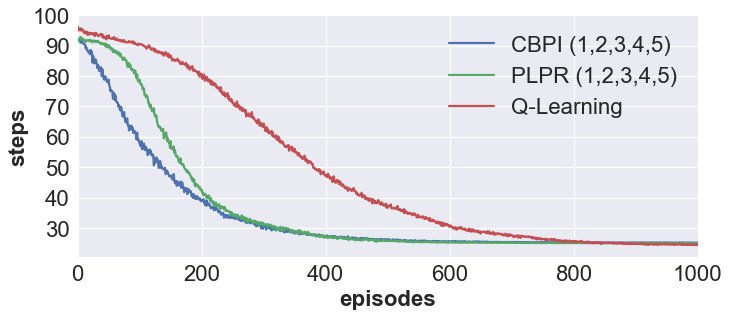

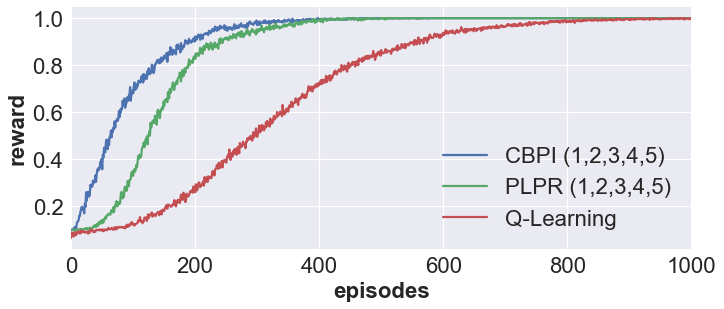

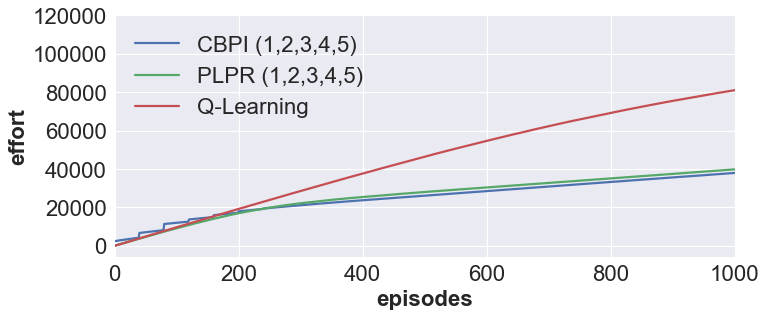

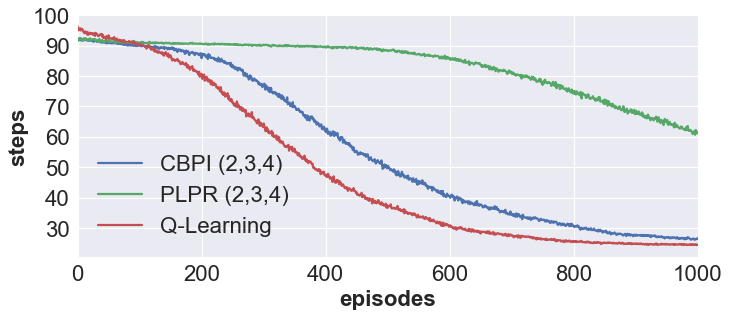

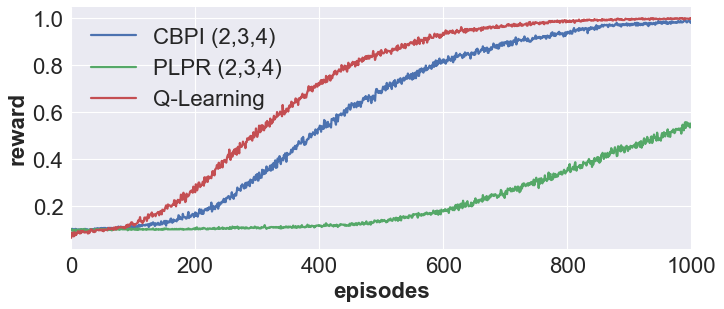

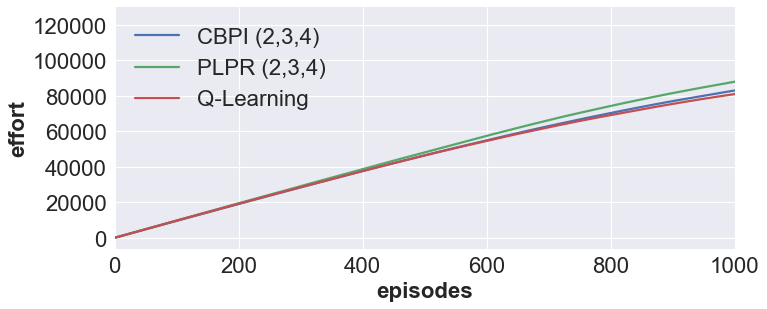

In [81]:
################################
####### TiRL short paper #######
################################
# Standard Q-Learning results
experiment_1 = ['Q-Learning',
                '/Users/rubenglatt/playground/CBPI/results_TiRL/2017-02-20_02-04_q_policyreuse2006/task_omega/']
# CBPI selective
experiment_2 = ['CBPI',
                '/Users/rubenglatt/playground/CBPI/results_TiRL/2017-02-23_22-08_cbpi_policyreuse2006/task_omega/']

################################
################################


################################
### Interesting experiments ####
################################

# Improved Standard Q-Learning results(50 runs per task and test every episode) --> BASELINE
experiment_3 = ['Q-Learning',
                '/Users/rubenglatt/playground/CBPI/logs/1_2017-03-18_16-28_q_policyreuse2006/task_omega/']

# CBPI (50 runs per task and test every episode) probably not right!!!
experiment_4 = ['CBPI',
                '/Users/rubenglatt/playground/CBPI/logs/1_2017-03-15_22-31_cbpi_policyreuse2006/task_omega/']


################################
### Massively improved CBPI ####
################################

# CBPI (10 runs per task and test every 10 episodes) 
experiment_5 = ['CBPI',
                '/Users/rubenglatt/playground/CBPI/logs/2017-03-23_19-58_cbpi_policyreuse2006/task_omega/']

# CBPI (10 runs per task and test every episode) 
experiment_5 = ['CBPI',
                '/Users/rubenglatt/playground/CBPI/logs/2017-04-10_18-01_cbpi_policyreuse2006/task_omega/']

# CBPI (10 runs per task and test every episode) 
experiment_6 = ['CBPI (1,2,3,4,5)',
                '/Users/rubenglatt/playground/CBPI/logs/2017-04-11_03-37_cbpi_policyreuse2006/task_omega/']

# CBPI (10 runs per task and test every episode) 
experiment_6a = ['CBPI (1,2,3,4,5)',
                '/Users/rubenglatt/playground/CBPI/logs/2017-04-11_05-13_cbpi_policyreuse2006/task_omega/']


################################
### PLPR                    ####
################################

# PLPR (10 runs, test every 10)
experiment_7 = ['PLPR (random)',
                '/Users/rubenglatt/playground/CBPI/logs/2017-04-10_14-07_plpr_policyreuse2006/task_omega/']

# PLPR (10 runs, test every 10)
experiment_8 = ['PLPR (e-greedy)',
                '/Users/rubenglatt/playground/CBPI/logs/2017-04-10_14-53_plpr_policyreuse2006/task_omega/']

# PLPR (10 runs, test every 10)
experiment_9 = ['PLPR (1)',
                '/Users/rubenglatt/playground/CBPI/logs/2017-04-10_14-18_plpr_policyreuse2006/task_omega/']

# PLPR (10 runs, test every 10)
experiment_10 = ['PLPR (2)',
                '/Users/rubenglatt/playground/CBPI/logs/2017-04-10_14-23_plpr_policyreuse2006/task_omega/']

# PLPR (10 runs, test every 10)
experiment_11 = ['PLPR (3)',
                '/Users/rubenglatt/playground/CBPI/logs/2017-04-10_14-27_plpr_policyreuse2006/task_omega/']

# PLPR (10 runs, test every 10)
experiment_12 = ['PLPR (5)',
                '/Users/rubenglatt/playground/CBPI/logs/2017-04-10_14-30_plpr_policyreuse2006/task_omega/']

# PLPR (10 runs, test every 10)
experiment_13 = ['PLPR (2,3,4)',
                '/Users/rubenglatt/playground/CBPI/logs/2017-04-10_15-12_plpr_policyreuse2006/task_omega/']

# PLPR (10 runs, test every 10)
experiment_14 = ['PLPR (1,2,3,4)',
                '/Users/rubenglatt/playground/CBPI/logs/2017-04-10_15-15_plpr_policyreuse2006/task_omega/']

# PLPR (10 runs, test every 10)
experiment_15 = ['PLPR (2,3,4,5)',
                '/Users/rubenglatt/playground/CBPI/logs/2017-04-10_15-17_plpr_policyreuse2006/task_omega/']

# PLPR (10 runs, test every 1)
experiment_16 = ['PLPR (1,2,3,4,5)',
                '/Users/rubenglatt/playground/CBPI/logs/2017-04-11_02-25_plpr_policyreuse2006/task_omega/']

# PLPR (10 runs, test every 1)
experiment_17 = ['PLPR (2,3,4)',
                '/Users/rubenglatt/playground/CBPI/logs/2017-04-11_03-42_plpr_policyreuse2006/task_omega/']

# PLPR (10 runs, test every 1)
experiment_18 = ['CBPI (2,3,4)',
                '/Users/rubenglatt/playground/CBPI/logs/2017-04-11_05-20_cbpi_policyreuse2006/task_omega/']

# PLPR (10 runs, test every 1)
experiment_18a = ['CBPI (2,3,4)',
                '/Users/rubenglatt/playground/CBPI/logs/2017-04-11_23-57_cbpi_policyreuse2006/task_omega/']

# Q-Learning results(10 runs per task and test every episode) --> BASELINE
experiment_19 = ['Q-Learning',
                '/Users/rubenglatt/playground/CBPI/logs/2017-04-11_13-27_q_policyreuse2006/task_omega/']

################################
####### ECML experiments #######
################################

# Q-Learning results(50 runs, test every episode) --> BASELINE
ecml_q = ['Q-Learning',
          '/Users/rubenglatt/playground/CBPI/results_ECML/2017-04-12_02-07_q_policyreuse2006/task_omega/']

# PLPR (50 runs, test every 1) --> Library contains good policies (1,5) from very similar tasks
ecml_plpr_12345 = ['PLPR (1,2,3,4,5)',
                   '/Users/rubenglatt/playground/CBPI/results_ECML/2017-04-11_21-42_plpr_policyreuse2006/task_omega/']

# PLPR (50 runs, test every 1) --> Library contains only bad policies (2,3,4) from not similar tasks
ecml_plpr_234 = ['PLPR (2,3,4)',
                   '/Users/rubenglatt/playground/CBPI/results_ECML/2017-04-11_22-22_plpr_policyreuse2006/task_omega/']

# PLPR (50 runs, test every 1) --> Library contains good policies (1,5) from very similar tasks
ecml_cbpi_12345 = ['CBPI (1,2,3,4,5)',
                   '/Users/rubenglatt/playground/CBPI/results_ECML/2017-04-12_01-37_cbpi_policyreuse2006/task_omega/']

# PLPR (50 runs, test every 1) --> Library contains only bad policies (2,3,4) from not similar tasks
ecml_cbpi_234 = ['CBPI (2,3,4)',
                   '/Users/rubenglatt/playground/CBPI/results_ECML/2017-04-12_01-00_cbpi_policyreuse2006/task_omega/']

#plot_compare(experiment_1, experiment_2)

plot_compare(ecml_cbpi_12345, ecml_plpr_12345, ecml_q)
plot_compare(ecml_cbpi_234, ecml_plpr_234, ecml_q)
